## Wine Review Classification 

### 1.1 Imports

In [4]:
import nltk
import joblib
import fasttext
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
from nltk.text import Text
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.draw.dispersion import dispersion_plot
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report, precision_recall_curve
from sklearn.svm import LinearSVC
from gensim.models.phrases import Phrases, Phraser
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier


#from fasttext import train_supervised
#import tensorflow
#import tensorflow_hub as hub
#import tensorflow_text as tf_text
#from tensorflow import tensorflow_text as text



### 1.2 Initializing Data

In [5]:
sub_df_1 = pd.read_csv('data/winemag-data_first150k.csv')
sub_df_2 = pd.read_csv('data/winemag-data-130k-v2.csv')
df =  pd.concat([sub_df_1, sub_df_2], ignore_index=True)

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                280833 non-null  object 
 1   description            280901 non-null  object 
 2   designation            197701 non-null  object 
 3   points                 280901 non-null  int64  
 4   price                  258210 non-null  float64
 5   province               280833 non-null  object 
 6   region_1               234594 non-null  object 
 7   region_2               111464 non-null  object 
 8   variety                280900 non-null  object 
 9   winery                 280901 non-null  object 
 10  taster_name            103727 non-null  object 
 11  taster_twitter_handle  98758 non-null   object 
 12  title                  129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 27.9+ MB


In [9]:
df['province'].unique()

array(['California', 'Northern Spain', 'Oregon', 'Provence',
       'Northeastern Italy', 'Southwest France', 'Kumeu', 'Washington',
       'Bulgaria', 'Tuscany', 'France Other', 'Rhône Valley', 'Galicia',
       'Andalucia', 'Idaho', 'Burgundy', 'Loire Valley', 'New York',
       'Mendoza Province', 'Victoria', 'Alentejano', 'Piedmont',
       'Alentejo', 'Champagne', 'Upper Galilee', 'Beira Atlantico',
       'Veneto', 'Douro', 'Tejo', 'Stellenbosch', 'Levante',
       'Sicily & Sardinia', 'Southern Italy', 'Languedoc-Roussillon',
       'Bordeaux', 'Atalanti Valley', 'Catalonia', 'Santorini', 'Florina',
       'Marchigue', 'Colchagua Valley', 'Curicó Valley', 'Nemea',
       'Maule Valley', 'Alsace', 'Guerrouane', 'Colinele Dobrogei',
       'Central Spain', 'Vinho Verde', 'Mosel', 'Rheinhessen',
       'Golan Heights', 'Württemberg', 'Ahr', 'British Columbia',
       'Moldova', 'Spain Other', 'Sopron', 'Other', 'Walker Bay', 'Dão',
       'Italy Other', 'Duriense', 'Ontario', 'Beir

### 1.3 Data Cleaning

Are there any missing values?

Features with any missing value: 10/13


<AxesSubplot:title={'center':'Fraction of NaN values in the data'}>

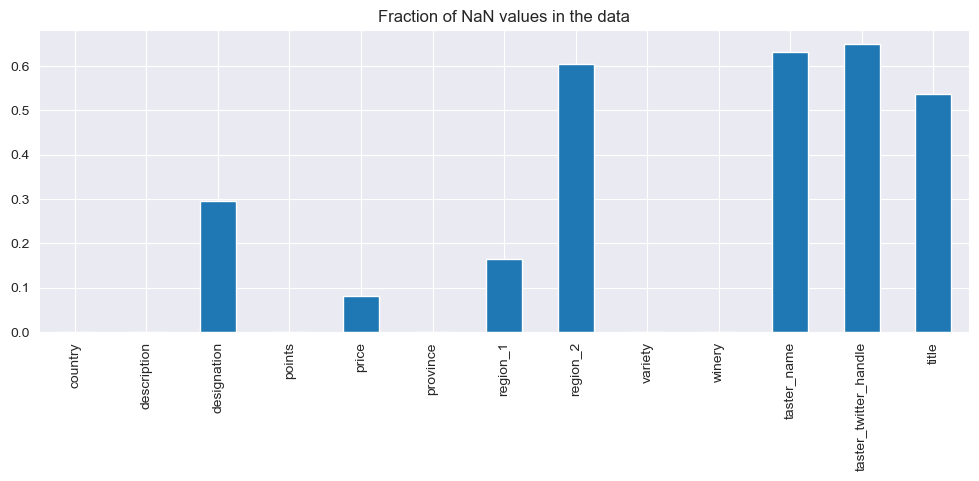

In [10]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
print(f'Features with any missing value: {df.isna().any().sum()}/{df.shape[1]}')
df.isna().mean().plot.bar(ax=ax, title='Fraction of NaN values in the data')

We can see that the features 'designation', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle' and 'title' have a significant amount of missing data. We'll drop these anyways. We also need to drop the rows that has NaN as price. 

In [11]:
#df = df.drop(columns=['Unnamed: 0'])
df = df[df['price'].notna()]
df = df.drop(columns=['designation', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title'])

Are there any NaN values left?

Features with any missing value: 3/7


<AxesSubplot:title={'center':'Fraction of NaN values in the data'}>

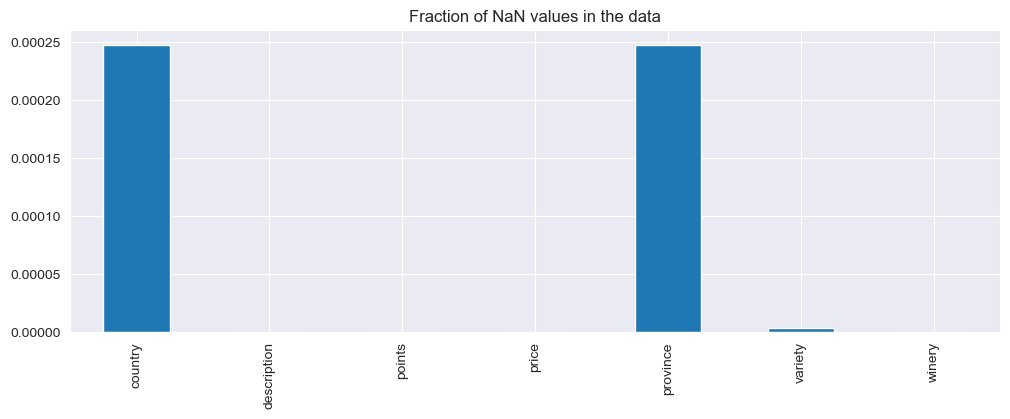

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
print(f'Features with any missing value: {df.isna().any().sum()}/{df.shape[1]}')
df.isna().mean().plot.bar(ax=ax, title='Fraction of NaN values in the data')

Small amount, but yes....

In [13]:
df = df[df['province'].notna()]
df = df[df['variety'].notna()]

In [14]:
print(f'Features with any missing value: {df.isna().any().sum()}/{df.shape[1]}')

Features with any missing value: 0/7


In [15]:
df.shape

(258145, 7)

We've removed approx. 23K rows.

### 1.4 Exploratory Data Analysis

In [16]:
df.points.describe()

count    258145.000000
mean         88.084855
std           3.155957
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

Seems like these reviews contain high-level-wines, with a median of 88 points, and a minimum of 80 points.

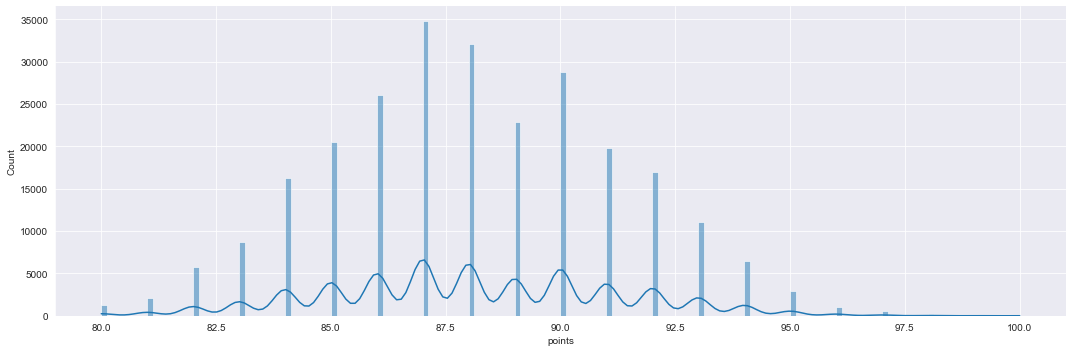

In [17]:
sns.displot(df.points, kde=True, aspect=3)

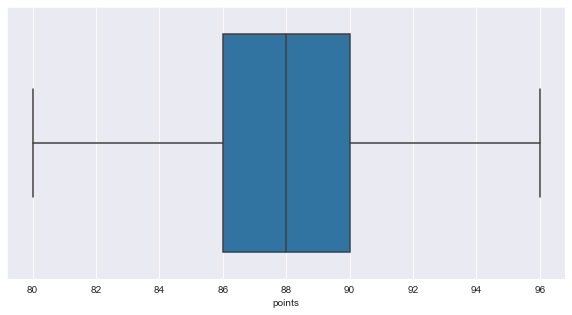

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df.points, showfliers=False)
plt.show()

In [19]:
df.points.median()

88.0

Seemingly normal distributed between 80 points and 97.5 points.

In [20]:
df.price.describe()

count    258145.000000
mean         34.179725
std          38.615971
min           4.000000
25%          16.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

We can observe that the price differs from the min of 4 USD, to the max of 3300 USD, with a median of 25 USD. Maybe we should look at the 95% quantile?

In [21]:
df.price.quantile(0.95)

80.0

The 95% quantile of price is 80 USD.

In [22]:
fixed_price = df.price[df.price < 81]
fixed_price.describe()

count    245266.000000
mean         28.609473
std          16.523063
min           4.000000
25%          16.000000
50%          24.000000
75%          38.000000
max          80.000000
Name: price, dtype: float64

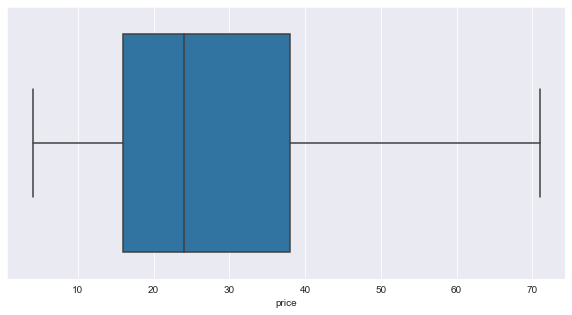

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=fixed_price, showfliers=False)
plt.show()

Here we can see the distribution of prices between 0 USD and 80 USD, with the median of 24 USD marked as a red vertical line. 

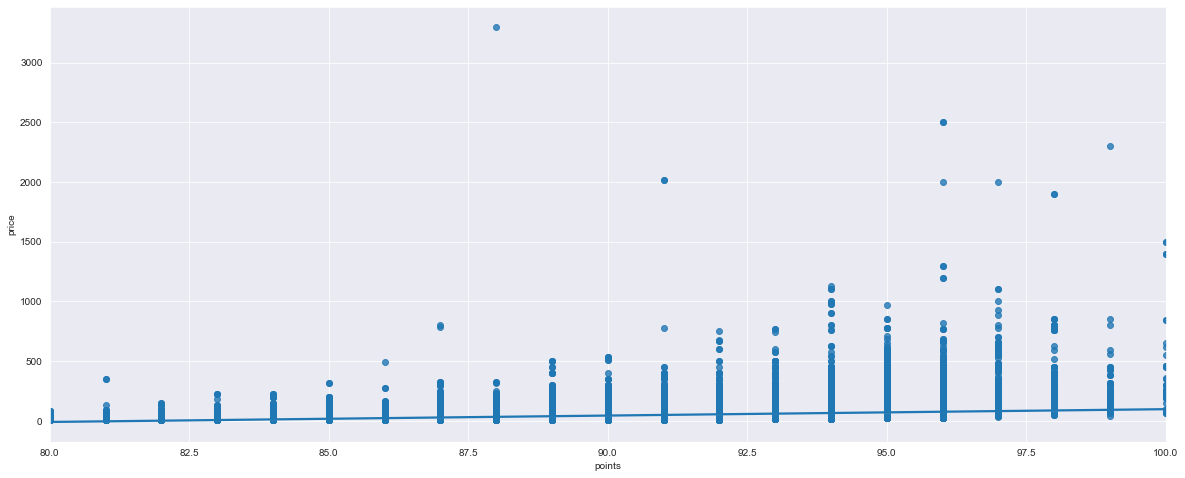

Correlation between 'price' and 'points': 0.437


In [24]:
plt.figure(figsize=(20, 8))
sns.regplot(x=df.points, y=df.price)
plt.show()
print("Correlation between 'price' and 'points': " + str(round(df.price.corr(df.points), 3)))

In [25]:
df.country = df.country.astype(str)

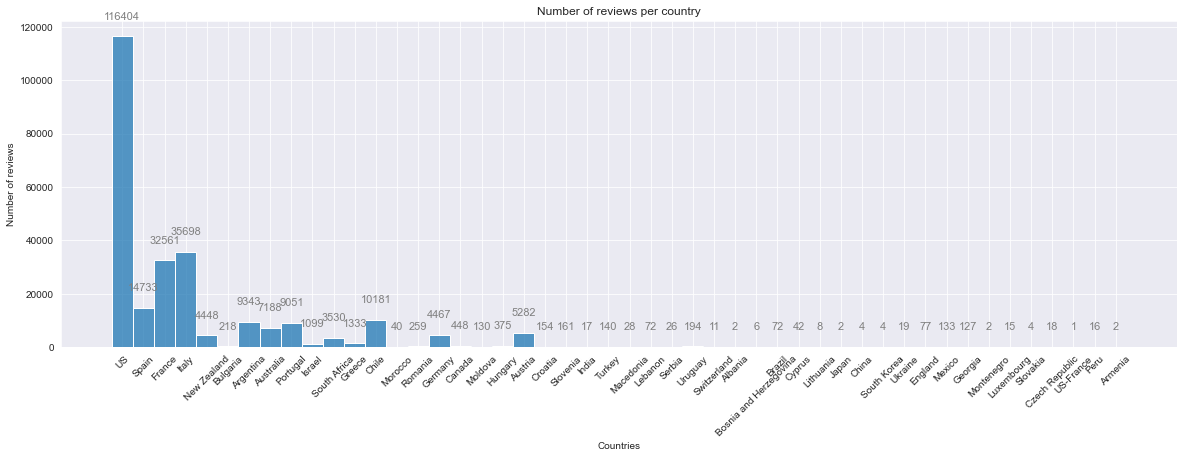

In [26]:
plt.figure(figsize=(20, 6))
all_contr = sns.histplot(df.country)
plt.xticks(rotation=45)
plt.xlabel('Countries')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per country')
for p in all_contr.patches:
    all_contr.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.show()

Wow...the US is overrepresentated. Lets look closer at top 10 countries:

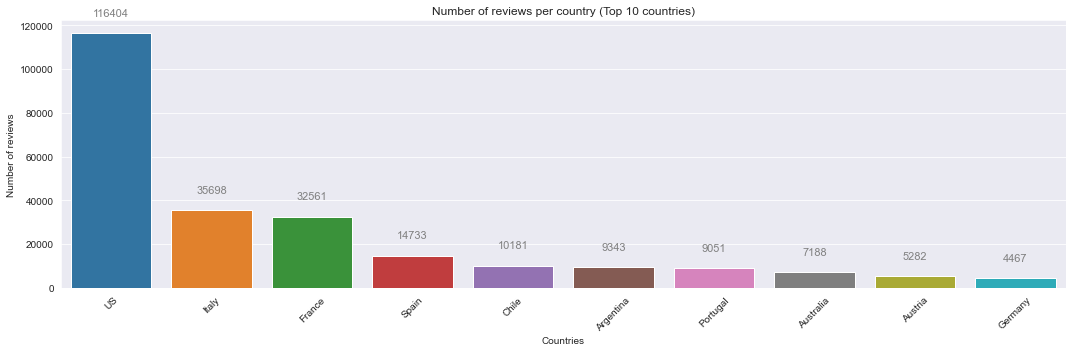

In [27]:
plt.figure(figsize=(15, 5))
h = sns.barplot(x=df.country.value_counts()[:10].index, y=df.country.value_counts()[:10].values)
plt.xticks(rotation=45)
plt.xlabel('Countries')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per country (Top 10 countries)')
for p in h.patches:
    h.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.tight_layout()

Lets check the average price for the top 10 most expensive countries

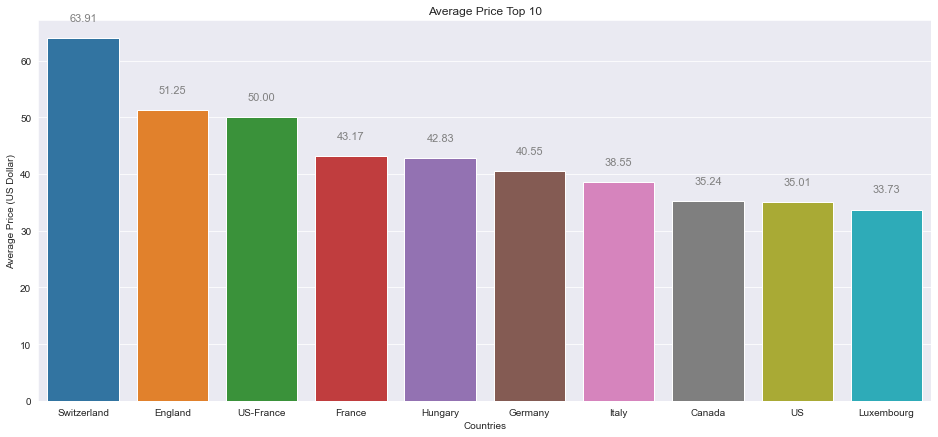

In [28]:
plt.figure(figsize=(16,7))
avg_price_topten = sns.barplot(x=df.groupby("country").mean().sort_values(by="price",ascending=False).price.index[:10], y=df.groupby("country").mean().sort_values(by="price", ascending=False).price.values[:10])
plt.xlabel("Countries")
plt.ylabel("Average Price (US Dollar)")
plt.title("Average Price Top 10")
for p in avg_price_topten.patches:
    avg_price_topten.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.show()

...And the average points for the top 10 highest rated countries

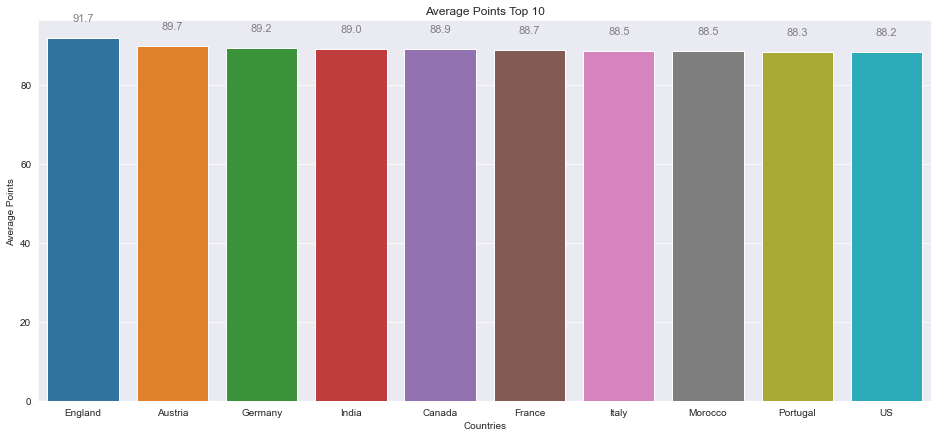

In [29]:
plt.figure(figsize=(16,7))
avg_points_topten = sns.barplot(x=df.groupby("country").mean().sort_values(by="points", ascending=False).points.index[:10], y=df.groupby("country").mean().sort_values(by="points", ascending=False).points.values[:10])
plt.xlabel('Countries')
plt.ylabel('Average Points')
plt.title('Average Points Top 10')
for p in avg_points_topten.patches:
    avg_points_topten.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.show()

In [30]:
df1 = df['variety'].value_counts().iloc[:25].rename_axis('val').reset_index(name='count')
df1.head()

,val,count
0,Pinot Noir,26410
1,Chardonnay,24852
2,Cabernet Sauvignon,22055
3,Red Blend,17843
4,Sauvignon Blanc,10834


In [31]:
df.iloc[3]

country                                                       US
description    This spent 20 months in 30% new French oak, an...
points                                                        96
price                                                       65.0
province                                                  Oregon
variety                                               Pinot Noir
winery                                                     Ponzi
Name: 3, dtype: object

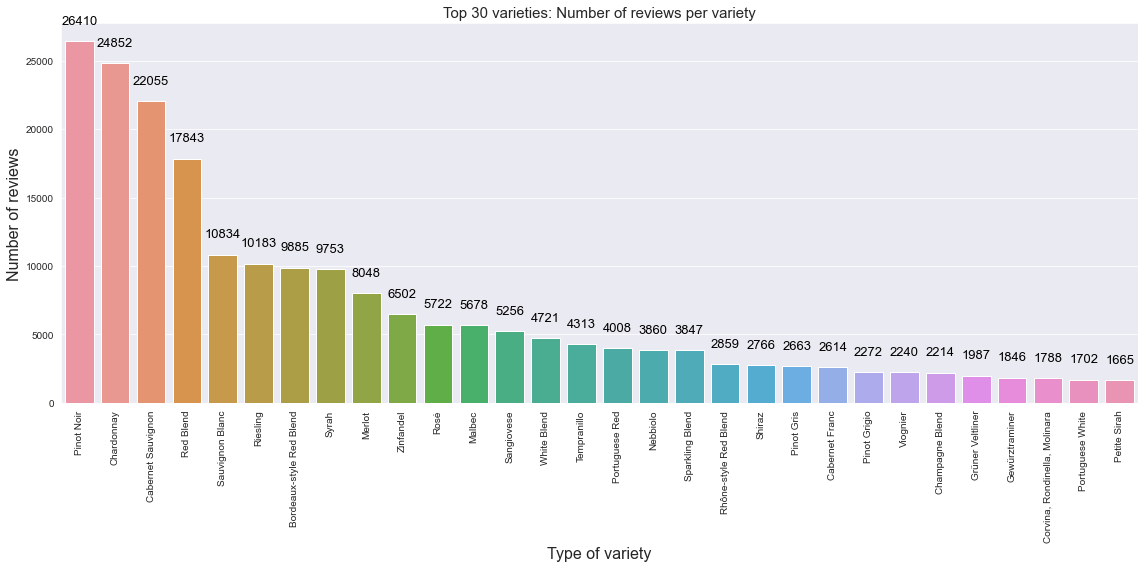

In [32]:
plt.figure(figsize=(16, 8))
grapes_bar = sns.barplot(x=df.variety.value_counts()[:30].index, y=df.variety.value_counts()[:30].values)
plt.xticks(rotation=90)
plt.xlabel('Type of variety', fontsize=16)
plt.ylabel('Number of reviews', fontsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.title('Top 30 varieties: Number of reviews per variety', fontsize=15)
for p in grapes_bar.patches:
    grapes_bar.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.tight_layout()

In [33]:
# Top 10 grapes
percent_grapes = df.variety.value_counts()[:10]
pie_df = pd.DataFrame({'percentage': percent_grapes})
pie_df

,percentage
Pinot Noir,26410
Chardonnay,24852
Cabernet Sauvignon,22055
Red Blend,17843
Sauvignon Blanc,10834
Riesling,10183
Bordeaux-style Red Blend,9885
Syrah,9753
Merlot,8048
Zinfandel,6502


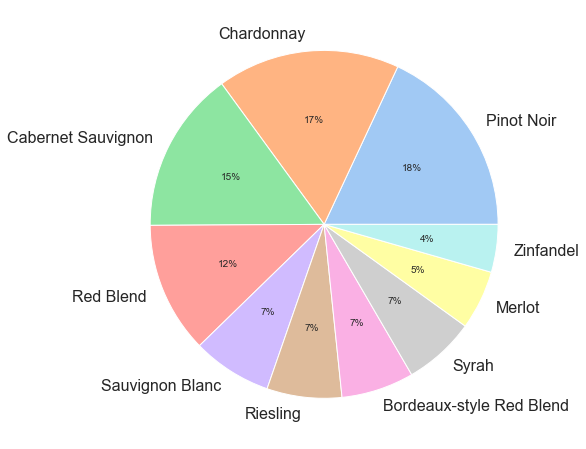

In [34]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:10]
plt.pie(pie_df.percentage, labels = pie_df.index, colors = colors, autopct='%.0f%%')
plt.show()

##### Dividing into classes

In [35]:
def variety_to_class(variety):
    if variety == 'Pinot Noir':
        return int(0)
    elif variety == 'Chardonnay':
        return int(1)
    elif variety == 'Cabernet Sauvignon':
        return int(2)
    elif variety == 'Sauvignon Blanc': 
        return int(3)
    elif variety == 'Riesling':
        return int(4)
    elif variety == 'Syrah':
        return int(5)
    elif variety == 'Merlot':
        return int(6)
    elif variety == 'Zinfandel':
        return int(7)

df['variety_class'] = df['variety'].apply(variety_to_class)

In [36]:
top_8_varieties = ['Cabernet Sauvignon', 'Pinot Noir', 'Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Syrah', 'Merlot', 'Zinfandel']

# selecting rows based on condition 
df = df.loc[df['variety'].isin(top_8_varieties)]
df.shape

(118637, 8)

In [37]:
df.head()

,country,description,points,price,province,variety,winery,variety_class
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Cabernet Sauvignon,Heitz,2.0
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,California,Sauvignon Blanc,Macauley,3.0
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Oregon,Pinot Noir,Ponzi,0.0
8,US,This re-named vineyard was formerly bottled as...,95,65.0,Oregon,Pinot Noir,Bergström,0.0
9,US,The producer sources from two blocks of the vi...,95,60.0,California,Pinot Noir,Blue Farm,0.0


In [38]:
df.variety_class.value_counts()

0.0    26410
1.0    24852
2.0    22055
3.0    10834
4.0    10183
5.0     9753
6.0     8048
7.0     6502
Name: variety_class, dtype: int64

We can observe that we have an imbalanced amount of data for the different classes.

### 1.5 Text Cleaning

In [39]:
class TextCleaner:
    def __init__(self, text):
        self.text = text
        self.stemmer = PorterStemmer() # Stemmer 
        self.stopwords = set(stopwords.words('english'))  # Stopwords
        self.lem = WordNetLemmatizer()  # Lemmatizer
        self.unwanted_words = ['drink', 'flavors', 'aromas', 'finish', 'ready', 'palate', 'offers', 'nose', 'wine', 'shows', 'notes', 
                            'cabernet', 'sauvignon', 'pinot', 'noir', 'chardonnay', 'blanc', 'riesling', 'syrah', 'merlot', 'zinfandel']

    def tokenize(self):
        self.text = word_tokenize(self.text)

    def lowercase(self):
        self.text = [word.lower() for word in self.text] 

    def remove_stopwords(self):
        self.text = [word for word in self.text if word not in self.stopwords and word.isalpha() and word not in self.unwanted_words]

    def lemmatize(self):
        self.text = [self.lem.lemmatize(word) for word in self.text]

    def port_stemmer(self):
        self.text = [self.stemmer.stem(word) for word in self.text]

    def clean(self):
        self.tokenize()
        self.lowercase()
        self.remove_stopwords()
        self.lemmatize()
        self.port_stemmer()
        
        return " ".join(self.text)

In [40]:
clean = lambda text: TextCleaner(text).clean()
df['description_cleaned'] = df.description.apply(clean)

In [41]:
def clean_review_tokenized(review):
  review = word_tokenize(review.lower())
  return [token for token in review]

In [42]:
df['description_cleaned_tokenized'] = df['description_cleaned'].apply(clean_review_tokenized)

### 1.6 Text Analysis

##### Number of Words per review

In [43]:
#inline function to produce word count, splitting on spaces
df['word_count'] = df['description'].apply(lambda x: len(str(x).split(" ")))
df.word_count.describe()

count    118637.000000
mean         40.483205
std          12.074477
min           3.000000
25%          32.000000
50%          40.000000
75%          48.000000
max         135.000000
Name: word_count, dtype: float64

In [44]:
df['word_count_cleaned'] = df['description_cleaned'].apply(lambda x: len(str(x).split(" ")))
df.word_count.describe()

count    118637.000000
mean         40.483205
std          12.074477
min           3.000000
25%          32.000000
50%          40.000000
75%          48.000000
max         135.000000
Name: word_count, dtype: float64

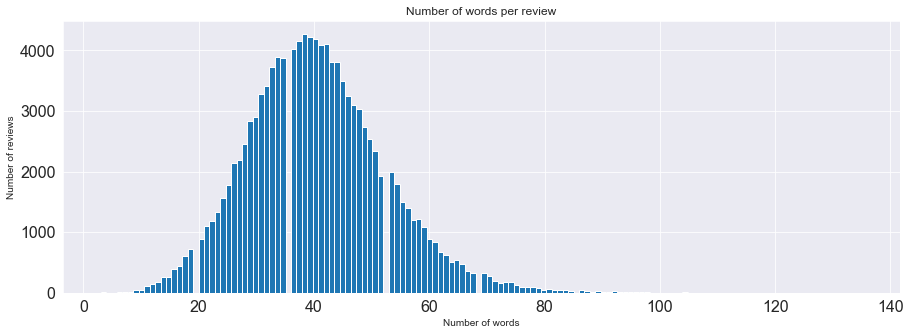

In [45]:
plt.figure(figsize=(15, 5))
plt.hist(df.word_count, bins=140)
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.title('Number of words per review')
plt.show()

In [46]:
print(df.description[70])

Sweetened tannins highlight a depth of chocolate and blackberry in this 100% varietal wine made in small amounts. Soft and juicy, it crafts a balance of richness and density around elegant spicy clove and cinnamon.


In [47]:
print(df.description_cleaned[70])

sweeten tannin highlight depth chocol blackberri variet made small amount soft juici craft balanc rich densiti around eleg spici clove cinnamon


In [48]:
word_freq_2 = df['description'].str.split(expand=True).stack().value_counts()
total_words_2 = sum(word_freq_2)
total_words_2


4801813

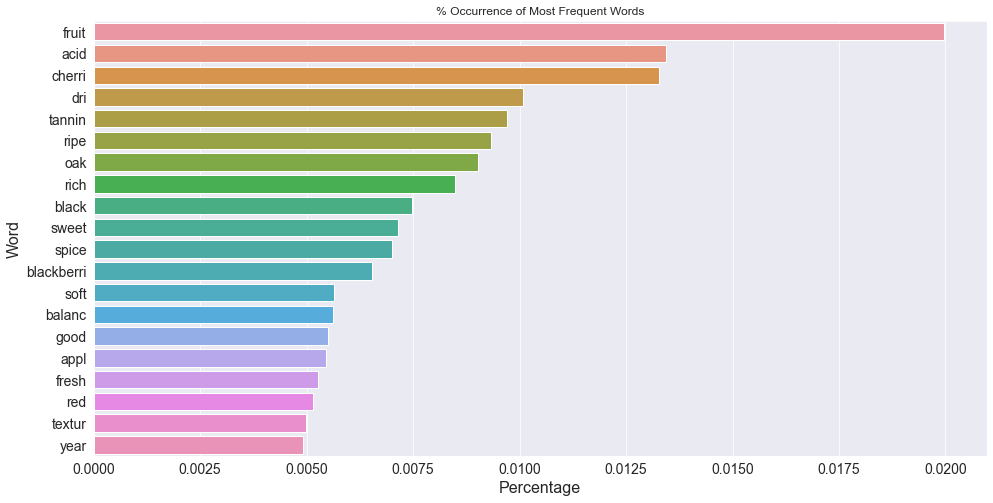

In [49]:
word_freq_ = df['description_cleaned'].str.split(expand=True).stack().value_counts()
total_words_ = sum(word_freq_)

# plot most common words 
top_words_ = word_freq_[:20]/total_words_

plt.figure(figsize=(16, 8))
ax = sns.barplot(x = top_words_.values, y = top_words_.index)
ax.set_title("% Occurrence of Most Frequent Words")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel('Percentage', fontsize=16)
plt.ylabel('Word', fontsize=16)
plt.show()

In [50]:
total_words_

2471264

##### Top 20 most common Bigrams

In [51]:
all_reviews_tokenized = []
for row in df['description_cleaned_tokenized']:
    for word in row:
        all_reviews_tokenized.append(word)

In [52]:
bigrams = nltk.FreqDist(nltk.bigrams(all_reviews_tokenized)).most_common(20)

In [53]:
bigram_df = pd.DataFrame(bigrams)
bigram_df.columns = ['bigram', 'freq']

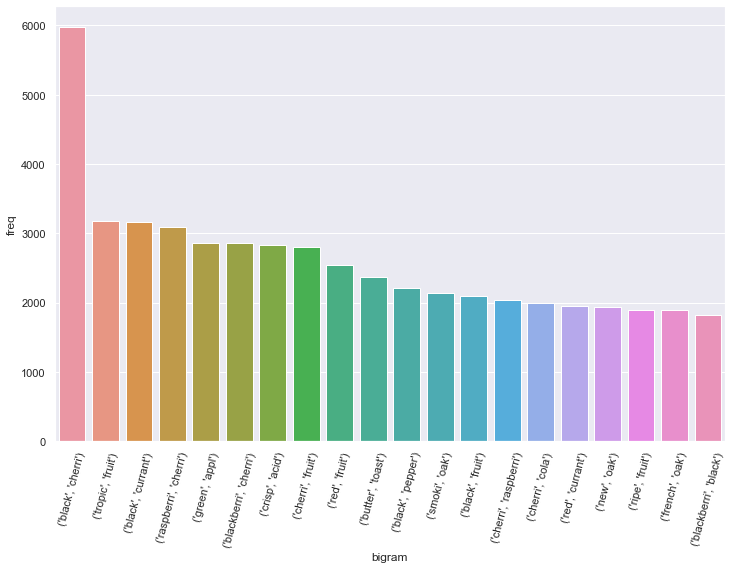

In [54]:
fig = sns.set(rc = {'figure.figsize':(12,8)})
bp = sns.barplot(x = "bigram", y = "freq", data = bigram_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation = 75)
plt.show()

##### Top 20 most common trigrams 

In [55]:
trigrams = nltk.FreqDist(nltk.trigrams(all_reviews_tokenized)).most_common(20)

In [56]:
trigram_df = pd.DataFrame(trigrams)
trigram_df.columns = ['trigram', 'freq']

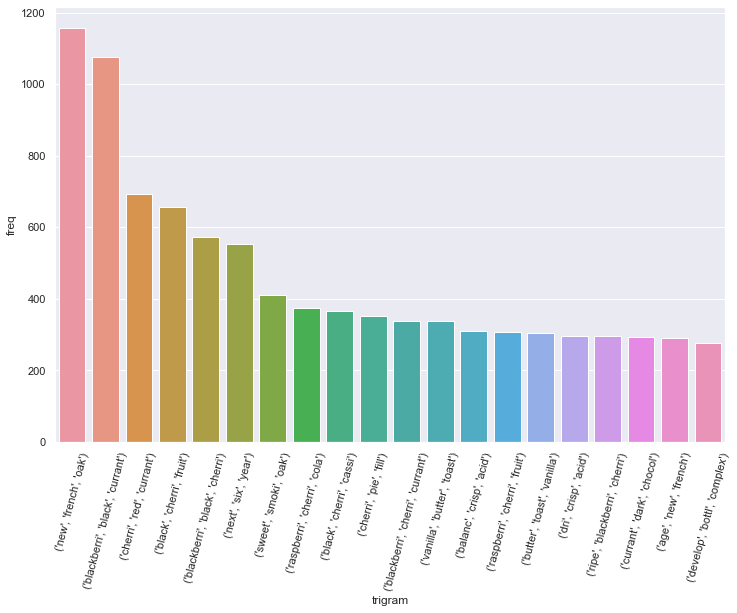

In [57]:
fig = sns.set(rc = {'figure.figsize':(12,8)})
bp = sns.barplot(x = "trigram", y = "freq", data = trigram_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation = 75)
plt.show()

In [58]:
varietal_counts = df.variety.value_counts()
print(varietal_counts[:20])

Pinot Noir            26410
Chardonnay            24852
Cabernet Sauvignon    22055
Sauvignon Blanc       10834
Riesling              10183
Syrah                  9753
Merlot                 8048
Zinfandel              6502
Name: variety, dtype: int64


##### Train/Test split

In [59]:
# Shuffle the dataframe before splitting in train/test
df = df.sample(frac=1).reset_index(drop=True)

In [84]:
train, test = train_test_split(df, test_size=0.3)

X_train = train['description_cleaned'].values
X_test = test['description_cleaned'].values
y_train = train['variety_class'].values
y_test = test['variety_class'].values

In [85]:
print('Train: ' + str(X_train.shape))
print('Test: ' + str(X_test.shape))

Train: (83045,)
Test: (35592,)


### 1.7 TfID Vectorizer

In [86]:
import networkx as nx
from collections import OrderedDict
from tqdm import tqdm

In [88]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

In [89]:
vectorizer.fit(X_train)
X_train_tfidf = vectorizer.transform(X_train)
dic_vocabulary = vectorizer.vocabulary_

In [90]:
X_train_tfidf = X_train_tfidf.toarray()
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)

c:\Users\Torkild\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [91]:
X_train_tfidf = pd.DataFrame(X_train_tfidf, columns=vocab)

In [92]:
X_train_tfidf

,abil,abl,abound,absenc,absolut,absolut delici,absolut dri,abund,abv,acacia,...,zin,zin dri,zinfandel,zing,zingi,zingi acid,zinni,zip,zippi,zippi acid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
from tqdm import tqdm
from itertools import combinations

In [98]:
### PMI between words
window = 10 # sliding window size to calculate point-wise mutual information between words
names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )
occurrences = np.zeros((len(names), len(names)), dtype=np.int32)

In [ ]:
# Find the co-occurrences:
no_windows = 0
for l in tqdm(X_train, total=len(X_train)):

    

    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])

        for w in d:
            n_i[w] += 1
        for w1, w2 in combinations(d, 2):
            i1 = word2index[w1]
            i2 = word2index[w2]

            occurrences[i1][i2] += 1
            occurrences[i2][i1] += 1

### convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
p_ij = p_ij + 1E-9
for col in p_ij.columns:
    p_ij[col] = p_ij[col].apply(lambda x: math.log(x))

### 1.8 Neural Network

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [66]:
m, n = X_train.shape

In [67]:
n_labels = len(np.unique(np.array(y_train)))

In [68]:
input_layer_size = n                      # Dimension of features
hidden_layer_size = input_layer_size*2    # of units in hidden layer
output_layer_size = n_labels              # number of labels

In [69]:
def initializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [70]:
# define baseline model
def baseline_model():
    # create model
	model = Sequential()
	model.add(Dense(8, input_dim=4, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [71]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

<ipython-input-71-bf22d4220b38>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


In [72]:
kfold = KFold(n_splits=10, shuffle=True)

In [73]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: nan% (nan%)


c:\Users\Torkild\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Torkild\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Torkild\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\Torkild\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\User

### 1.8 FastText (Failed)

In [260]:
df.head()

,country,description,points,price,province,variety,winery,variety_class,description_cleaned,description_cleaned_tokenized,word_count
0,Austria,"A creamy style of Sauvignon Blanc, this has fl...",86,20.0,Niederösterreich,Sauvignon Blanc,Pratsch,3.0,creami style ripe citru pineappl bite acid add...,"[creami, style, ripe, citru, pineappl, bite, a...",35
1,US,"Shows the characteristics of young vines, a ja...",92,54.0,California,Pinot Noir,Merry Edwards,0.0,characterist young vine jammi forward fruiti o...,"[characterist, young, vine, jammi, forward, fr...",43
2,US,"Very tart, with barely ripe flavors of rhubarb...",84,32.0,Oregon,Syrah,Amalie Robert,5.0,tart bare ripe rhubarb wild raspberri late rel...,"[tart, bare, ripe, rhubarb, wild, raspberri, l...",40
3,US,A spectacular Pinot that succeeds due to super...,94,110.0,California,Pinot Noir,Brogan,0.0,spectacular succe due superior structur comple...,"[spectacular, succe, due, superior, structur, ...",52
4,Germany,"Stone and steel define this deeply mineral, dr...",90,17.0,Mosel,Riesling,Friedrich-Wilhelm-Gymnasium,4.0,stone steel defin deepli miner dri elegantli f...,"[stone, steel, defin, deepli, miner, dri, eleg...",35


In [261]:
col = ['description_cleaned', 'variety']

df_fast = df[col]
df_fast['variety'] = ['__label__'+ s for s in df['variety']]
#df_fast['description_cleaned']= df['text'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)

<ipython-input-261-cf7a5cb85ecb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fast['variety'] = ['__label__'+ s for s in df['variety']]


In [262]:
df_fast.head()

,description_cleaned,variety
0,creami style ripe citru pineappl bite acid add...,__label__Sauvignon Blanc
1,characterist young vine jammi forward fruiti o...,__label__Pinot Noir
2,tart bare ripe rhubarb wild raspberri late rel...,__label__Syrah
3,spectacular succe due superior structur comple...,__label__Pinot Noir
4,stone steel defin deepli miner dri elegantli f...,__label__Riesling


In [263]:
df_fast_train, df_fast_test = train_test_split(df_fast, test_size=0.3, shuffle=True, random_state=123)

In [264]:
print(df_fast_train.shape)
print(df_fast_test.shape)

(83045, 2)
(35592, 2)


In [265]:
#Will contain all the predictions for validation set for all the output variables
all_preds = []
#Iterating over all output variables to create separate models
#for col in tqdm(y_cols):
    
file_path = 'data/df_fast_train.csv'

#Saving the Output Variable and the text data to a csv
df_fast_train.to_csv(file_path, header=None, index=False, columns=['description_cleaned', 'variety']) 

In [266]:
#Training the model
model = train_supervised(input=file_path, label_prefix="__label__", lr=1.0, epoch=2, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)

NameError: name 'train_supervised' is not defined

In [ ]:
model.labels


[]

In [ ]:
df_fast_test['variety'].values

array(['__label__Merlot', '__label__Sauvignon Blanc',
       '__label__Chardonnay', ..., '__label__Cabernet Sauvignon',
       '__label__Chardonnay', '__label__Pinot Noir'], dtype=object)

In [ ]:
model.predict('littl sharp light bodi nice dri complex berri currant tobacco spice price nice real eleg sophist')

((), array([], dtype=float64))

### 1.9 Word Embedding: Word2Vec (Failed)

In [ ]:
# Create list of lists of unigrams
corpus_list = [review.split() for review in train['description_cleaned']]

In [ ]:
# Create the bigrams
bigram_model = Phrases(corpus_list)

# Apply the trained model to a sentence
for unigram_sentence in corpus_list:
    bigram_sentences = u' '.join(bigram_model[unigram_sentence])

# Get a trigram model out of the bigram
trigram_model = Phrases(bigram_sentences)

In [ ]:
# Fit word2vec
model_w2v = Word2Vec(corpus_list, vector_size=300, window=40, min_count=1, sg=1, epochs=30)

c:\Users\Torkild\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Torkild\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
<ipython-input-120-3334cf9e4d52>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_["input"].iloc[0:1] = 1


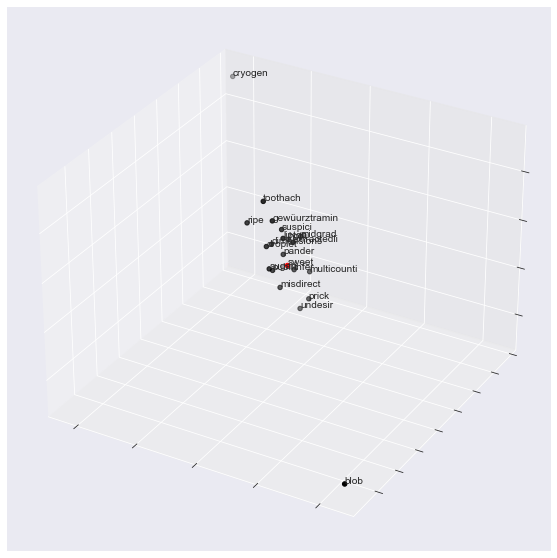

In [ ]:
word = "sweet"
fig = plt.figure(figsize=(10, 10))

## word embedding
tot_words = [word] + [tupla[0] for tupla in model_w2v.wv.most_similar(word, topn=20)]
X = model_w2v.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
model_w2v.wv.most_similar('rich')

[('ripe', 0.7077869176864624),
 ('opul', 0.5521456599235535),
 ('delici', 0.5400464534759521),
 ('bling', 0.5277560353279114),
 ('baldassari', 0.524911642074585),
 ('qua', 0.5223559737205505),
 ('perdrix', 0.519270658493042),
 ('sai', 0.5176070332527161),
 ('summar', 0.5169286727905273),
 ('je', 0.5109609961509705)]

### 2.0 Classification

##### Multinomial Naive Bayes

In [278]:
mb = MultinomialNB()

# Pipeline
mb_model = pipeline.Pipeline([('vectorizer', vectorizer), ('classifier', mb)])

# Train classifier
mb_model['classifier'].fit(X_train, y_train)

# Test
y_pred_mb = mb_model.predict(X_test)
mb_predicted_prob = mb_model.predict_proba(X_test)

Accuracy: 0.72
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         0.0       0.71      0.88      0.79      8054
         1.0       0.77      0.92      0.84      7335
         2.0       0.60      0.83      0.70      6646
         3.0       0.85      0.62      0.71      3210
         4.0       0.86      0.72      0.78      3087
         5.0       0.73      0.31      0.43      2937
         6.0       0.70      0.07      0.13      2438
         7.0       0.76      0.52      0.62      1885

    accuracy                           0.72     35592
   macro avg       0.75      0.61      0.63     35592
weighted avg       0.73      0.72      0.69     35592



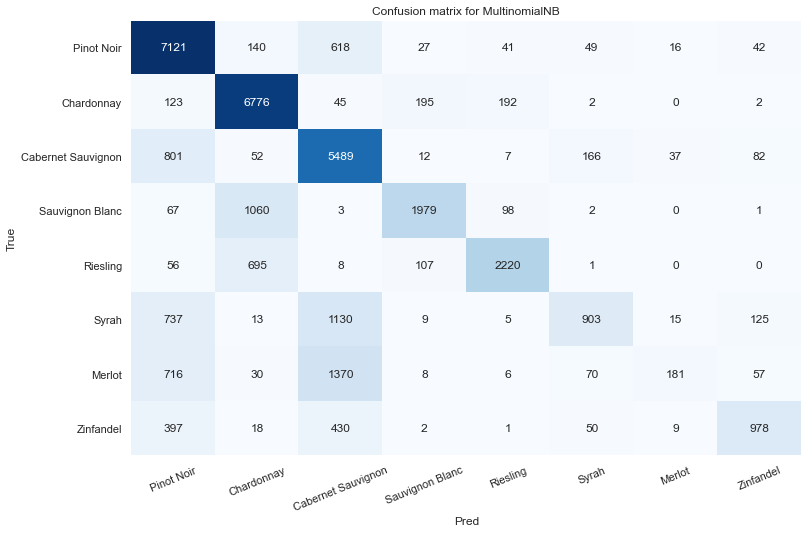

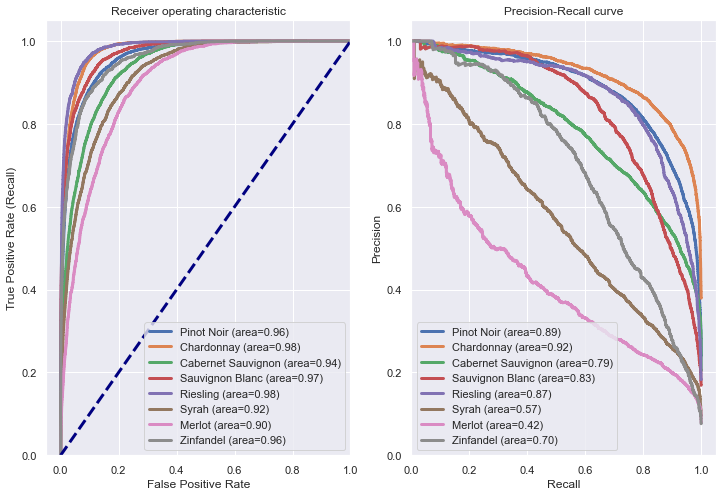

In [289]:
classes =  ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Riesling', 'Syrah', 'Merlot', 'Zinfandel']#np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
acc = accuracy_score(y_test, y_pred_mb)
auc = roc_auc_score(y_test, mb_predicted_prob, multi_class="ovr")
print("Accuracy:",  round(acc, 2))
print("Auc:", round(auc, 2))
print("Detail:")
print(classification_report(y_test, y_pred_mb))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_mb)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix for MultinomialNB")
plt.yticks(rotation=0)
plt.xticks(rotation=22.5)

fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], mb_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(str(classes[i]), metrics.auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], mb_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
        label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show() #0.72

We can see that the variety types with lower amounts of data, is harder to predict..

##### Linear Support Vector Classification

In [280]:
svc = LinearSVC()
svc_cc = CalibratedClassifierCV(svc)

# Pipeline
svc_model = pipeline.Pipeline([('vectorizer', vectorizer), ('classifier', svc_cc)])

# Train classifier
svc_model['classifier'].fit(X_train, y_train)

# Test
y_pred_svc = svc_model.predict(X_test)
svc_predicted_prob = svc_model.predict_proba(X_test)

Accuracy: 0.81
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      8054
         1.0       0.87      0.92      0.90      7335
         2.0       0.75      0.81      0.78      6646
         3.0       0.86      0.78      0.82      3210
         4.0       0.88      0.87      0.87      3087
         5.0       0.70      0.60      0.65      2937
         6.0       0.63      0.42      0.50      2438
         7.0       0.84      0.73      0.78      1885

    accuracy                           0.81     35592
   macro avg       0.79      0.75      0.77     35592
weighted avg       0.80      0.81      0.80     35592



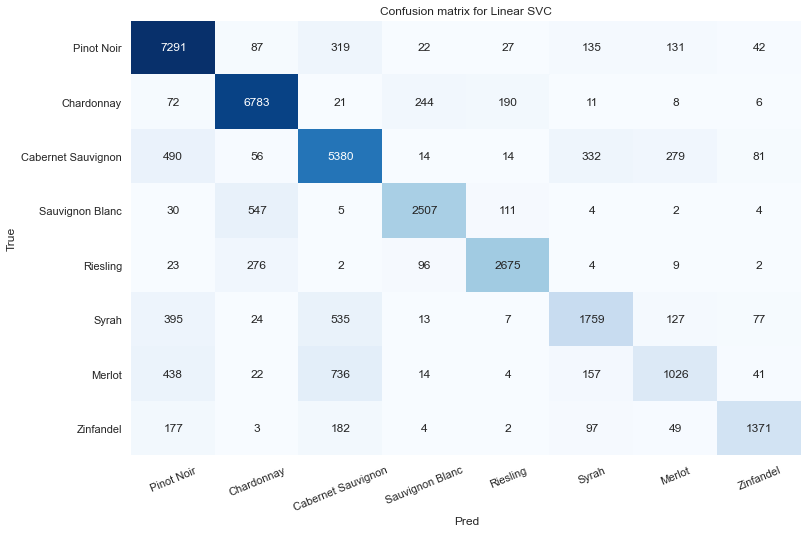

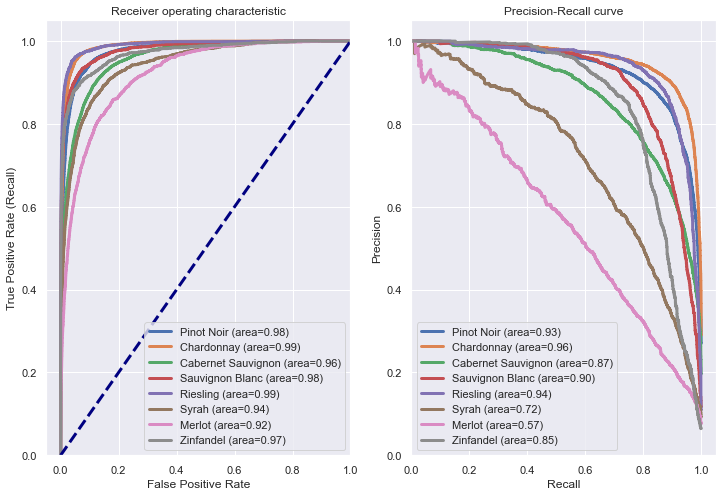

In [290]:
classes = ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Riesling', 'Syrah', 'Merlot', 'Zinfandel']
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
acc = accuracy_score(y_test, y_pred_svc)
auc = roc_auc_score(y_test, svc_predicted_prob, multi_class="ovr")
print("Accuracy:",  round(acc, 2))
print("Auc:", round(auc, 2))
print("Detail:")
print(classification_report(y_test, y_pred_svc))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix for Linear SVC")
plt.yticks(rotation=0)
plt.xticks(rotation=22.5)

fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], svc_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(str(classes[i]), metrics.auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], svc_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
        label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show() #0.81

##### SGD Classifier

In [282]:
# Initialize classifier
sgd = SGDClassifier(loss='hinge', class_weight='balanced')
sgd_cc = CalibratedClassifierCV(sgd)

# Pipeline
sgd_model = pipeline.Pipeline([('vectorizer', vectorizer), ('classifier', sgd_cc)])

# Train classifier
sgd_model['classifier'].fit(X_train, y_train)

# Test
y_pred_sgd = sgd_model.predict(X_test)
sgd_predicted_prob = sgd_model.predict_proba(X_test)

Accuracy: 0.76
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82      8054
         1.0       0.83      0.90      0.86      7335
         2.0       0.74      0.75      0.74      6646
         3.0       0.81      0.72      0.77      3210
         4.0       0.84      0.82      0.83      3087
         5.0       0.62      0.52      0.57      2937
         6.0       0.52      0.38      0.44      2438
         7.0       0.79      0.63      0.70      1885

    accuracy                           0.76     35592
   macro avg       0.74      0.70      0.72     35592
weighted avg       0.76      0.76      0.76     35592



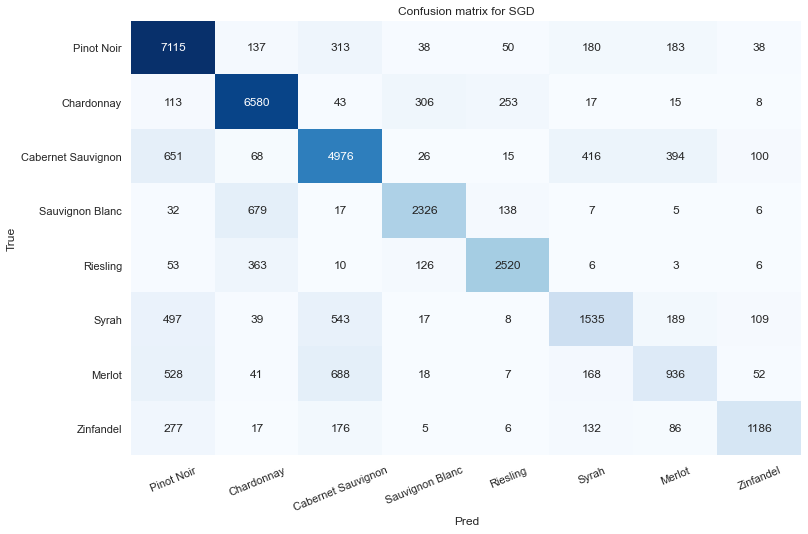

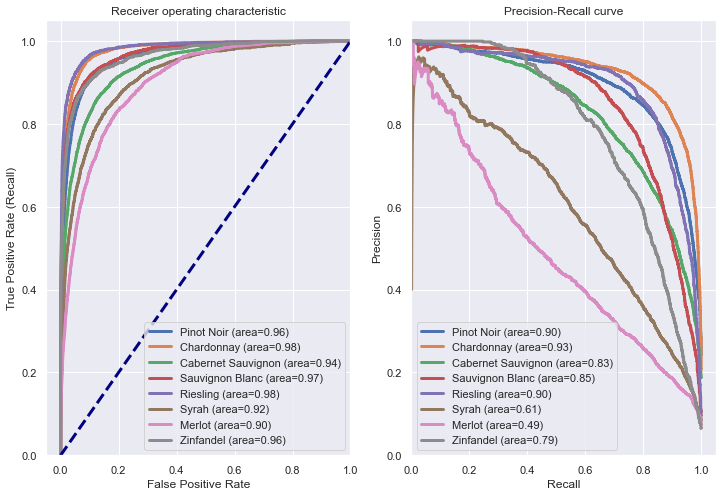

In [291]:
classes =  ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Riesling', 'Syrah', 'Merlot', 'Zinfandel']
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
acc = accuracy_score(y_test, y_pred_sgd)
auc = roc_auc_score(y_test, sgd_predicted_prob, multi_class="ovr")
print("Accuracy:",  round(acc, 2))
print("Auc:", round(auc, 2))
print("Detail:")
print(classification_report(y_test, y_pred_sgd))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_sgd)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix for SGD")
plt.yticks(rotation=0)
plt.xticks(rotation=22.5)

fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], sgd_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(str(classes[i]), metrics.auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], sgd_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
        label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show() #0.76

##### Random Forest Classifier

In [284]:
# Initialize classifier
rf = RandomForestClassifier()

# Pipeline
rf_model = pipeline.Pipeline([('vectorizer', vectorizer), ('classifier', rf)])

# Train classifier
rf_model['classifier'].fit(X_train, y_train)

# Test
y_pred_rf = rf_model.predict(X_test)
rf_predicted_prob = rf_model.predict_proba(X_test)

Accuracy: 0.87
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      8054
         1.0       0.85      0.97      0.91      7335
         2.0       0.81      0.90      0.85      6646
         3.0       0.94      0.80      0.86      3210
         4.0       0.95      0.83      0.88      3087
         5.0       0.93      0.70      0.80      2937
         6.0       0.98      0.59      0.74      2438
         7.0       0.96      0.75      0.85      1885

    accuracy                           0.87     35592
   macro avg       0.91      0.81      0.85     35592
weighted avg       0.88      0.87      0.86     35592



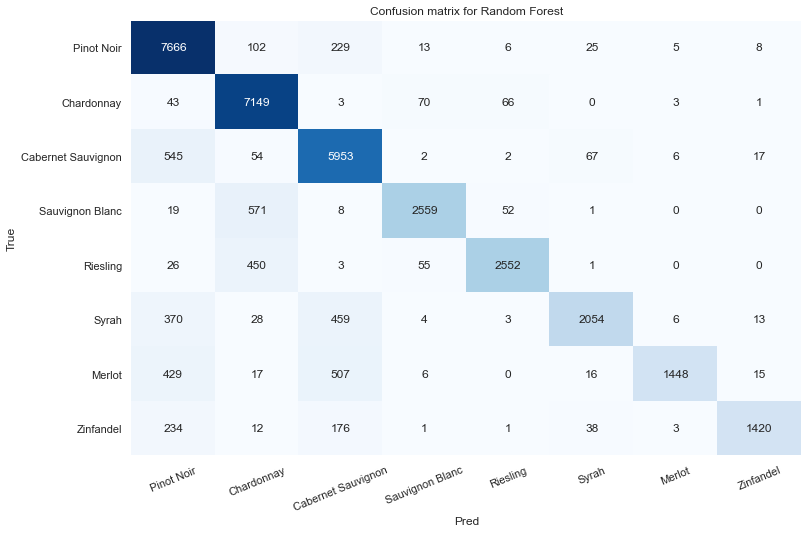

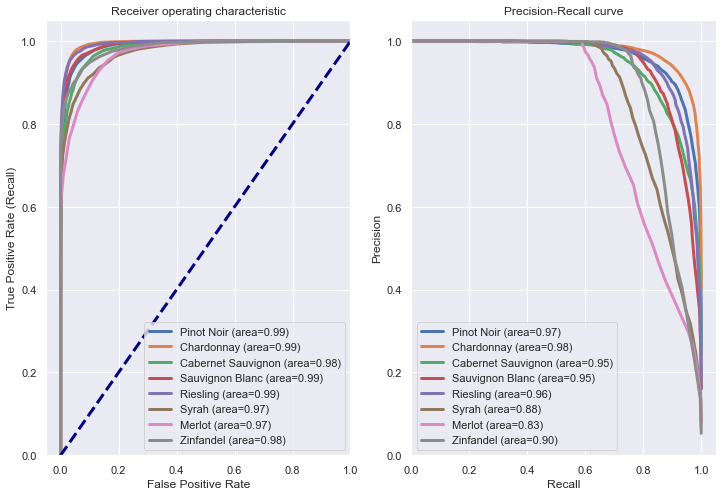

In [292]:
classes =  ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Riesling', 'Syrah', 'Merlot', 'Zinfandel']
y_test_array = pd.get_dummies(y_test, drop_first=False).values

# Accuracy, Precision, Recall
acc = accuracy_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, rf_predicted_prob, multi_class="ovr")
print("Accuracy:",  round(acc, 2))
print("Auc:", round(auc, 2))
print("Detail:")
print(classification_report(y_test, y_pred_rf))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix for Random Forest")
plt.yticks(rotation=0)
plt.xticks(rotation=22.5)

fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], rf_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(str(classes[i]), metrics.auc(fpr, tpr)))
ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], rf_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
        label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show() #0,87